In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error

In [2]:
df = pd.read_csv("data/train.csv")
df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [3]:
# drop 'id', 'breath_id', and 'pressure' from the predictors
X = df[['R', 'C', 'time_step', 'u_in', 'u_out']]
y = df['pressure']

## Split the data

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_val.shape)

Training set shape: (4828800, 5)
Test set shape: (1207200, 5)


In [5]:
lgb_model = lgb.LGBMRegressor(random_state=42)

param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'max_depth': [-1, 10, 20],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_absolute_error', 
                           verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (Negative MAE):", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 4828800, number of used features: 5
[LightGBM] [Info] Start training from score 11.220616
Best Parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 0.8}
Best CV Score (Negative MAE): -2.028893038045614


## Evaluate the model performance

In [6]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)
print("Mean Absolute Error (MAE):", mae)

mse  = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error (MSE):", mse)

rmse  = root_mean_squared_error(y_val, y_val_pred)
print("Root Mean Squared Error (RMSE) Score:", rmse)

r2 = r2_score(y_val, y_val_pred)
print("R2 Score:", r2)

Mean Absolute Error (MAE): 2.0306090122514497
Mean Squared Error (MSE): 15.640914282222097
Root Mean Squared Error (RMSE) Score: 3.954859578066217
R2 Score: 0.7622276595145944


## Prepare submission using the test dataset

In [7]:
df_test = pd.read_csv("data/test.csv")

# Prepare test features
X_test = df_test[['R', 'C', 'time_step', 'u_in', 'u_out']]

# Predict the pressure values for the test set
test_predictions = best_model.predict(X_test)

# Create a submission
submission_df = pd.DataFrame({
    "id": df_test["id"],
    "pressure": test_predictions
})

# Save the submission file as CSV
submission_df.to_csv("lightGBM.csv", index=False)
print("Submission file 'lightGBM.csv' created successfully.")

Submission file 'lightGBM.csv' created successfully.


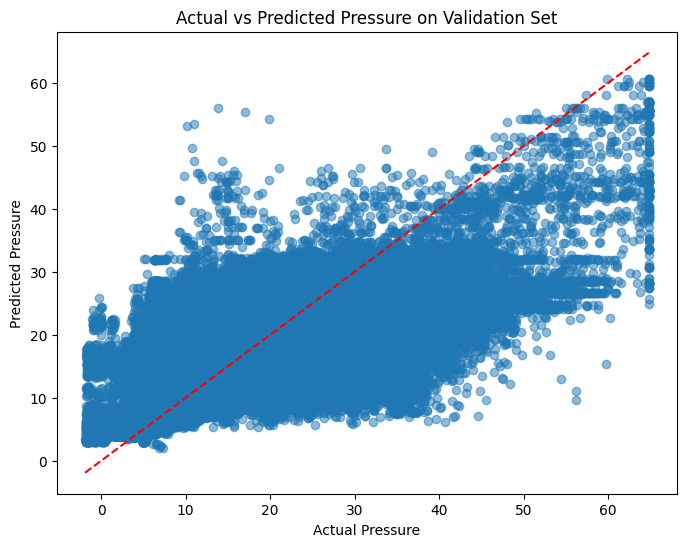

In [8]:
# Visualize Actual vs Predicted Pressure on the validation set
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.xlabel("Actual Pressure")
plt.ylabel("Predicted Pressure")
plt.title("Actual vs Predicted Pressure on Validation Set")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Diagonal line for ideal predictions
plt.show()